# Problem sugestion with MAB algorithms

In this work we use MAB algorithms to select problems to trainning competitive programming competitors.

## The dataset

The algorithms will be trainning using data from the URI Onlide Judge. At this moment, the dataset contains more than 200k solutions. Each solution is a list of tuples composed by `(user, problem, problem_category, date)`.

In [623]:
import random, math
from itertools import groupby
from collections import namedtuple
import pandas as pd
import matplotlib.pyplot as plt

In [624]:
solutions_df = pd.read_csv('solutions.csv')
solutions_df[:5]

,user,problem,category,date
0,40980,1001,1,15/02/25 06:15
1,40980,1002,1,15/02/25 07:10
2,40980,1003,1,15/02/25 06:17
3,40980,1004,1,15/02/25 06:19
4,40980,1005,1,15/02/25 07:31


In some tests, we need to select solutions from a specify category. So in theses cases, the first thing to do is filter the data. This is very important, once we work we a lot of data. Doing this first, we will reduce the amount of data to process in future tasks. In another words, this will speed up our work.

In [625]:
filter_category = 0

categories = [
    'All', #0
    'Beginner', #1
    'Ad-Hoc', #2
    'String', #3
    'Libraries', #4
    'Math', #5
    'Paradigms', #6
    'Graph', #7
    'Geometry', #8
]

category = categories[filter_category]

if filter_category:
    solutions_df = solutions_df.loc[solutions_df['category'] == filter_category]

solutions_df[:5]

,user,problem,category,date
0,40980,1001,1,15/02/25 06:15
1,40980,1002,1,15/02/25 07:10
2,40980,1003,1,15/02/25 06:17
3,40980,1004,1,15/02/25 06:19
4,40980,1005,1,15/02/25 07:31


In this step we need to get the set of problems and users in our dataset.

In [626]:
problems = list(set(solutions_df['problem']))
problems.sort()
problems[:5]

[1001, 1002, 1003, 1004, 1005]

In [627]:
users = list(set(solutions_df['user']))
users.sort()
users[:5]

[2, 83, 174, 276, 384]

Later, we will use the users and problems as a table. So is very important to have the identifiers starting from 0 and be sequential. And in this step, we need to guarantee this.

In [628]:
for i, user in enumerate(users):
    solutions_df.replace({'user': {user: i}}, inplace=True)

for i, problem in enumerate(problems):
    solutions_df.replace({'problem': {problem: i}}, inplace=True)
    
solutions_df[:5]

,user,problem,category,date
0,384,0,1,15/02/25 06:15
1,384,1,1,15/02/25 07:10
2,384,2,1,15/02/25 06:17
3,384,3,1,15/02/25 06:19
4,384,4,1,15/02/25 07:31


Updated the users and problems, we can see the new identifiers.

In [629]:
problems = list(set(solutions_df['problem']))
problems[:5]

[0, 1, 2, 3, 4]

In [630]:
users = list(set(solutions_df['user']))
users[:5]

[0, 1, 2, 3, 4]

As MAB are streaming algoritms, we will sort the solutions by the date, to simulate a real situation.

In [631]:
solutions_df = solutions_df.sort_values('date')
solutions_df[:5]

,user,problem,category,date
195525,0,0,1,12/03/01 04:12
195526,0,1,1,12/03/01 04:26
195527,0,2,1,12/03/01 04:28
195528,0,3,1,12/03/01 04:29
195613,0,6,1,12/03/01 04:44


The last step in this data tranform process is to create a list containg only the data that the algorithms need. The user and the problem of the solution.

In [632]:
Solution = namedtuple('Solution', 'problem, user')
solutions = []

for row in solutions_df.itertuples():
    solutions.append(
        Solution(row.problem, row.user)
    )
        
solutions[:5]

[Solution(problem=0, user=0),
 Solution(problem=1, user=0),
 Solution(problem=2, user=0),
 Solution(problem=3, user=0),
 Solution(problem=6, user=0)]

At this point we have everything that is necessary to test our algorithms.

In [633]:
class AnnealingEpsilonGreedy():
    def __init__(self, n_users, n_problems):
        self.n_arms = n_problems
        self.counts = [0     for col in range(self.n_arms)]
        self.values = [0.0   for col in range(self.n_arms)]
        self.chosen = [[0 for col in range(n_problems)] for col in range(n_users)]


    def max_arm(self, user):
        max_arm = 0
        max_value = -1
        
        for arm in range(self.n_arms):
            if self.chosen[user][arm]:
                continue
                
            if self.values[arm] > max_value:
                max_arm = arm
                max_value = self.values[arm]

        return max_arm

    
    def rand_arm(self, user):
        rand_arm = random.randrange(self.n_arms)
        
        while self.chosen[user][rand_arm]:
            rand_arm = (rand_arm + 1) % self.n_arms

        return rand_arm


    def select_arm(self, user):
        t = sum(self.counts) + 1
        epsilon = 1 / math.log(t + 0.0000001)
        
        if random.random() > epsilon:
            return self.max_arm(user)
        else:
            return self.rand_arm(user)
  

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value

In [634]:
def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    for i, prob in enumerate(probs):
        cum_prob += prob
        if cum_prob > z:
            return i
    
    return len(probs) - 1

class AnnealingSoftmax:
    def __init__(self, n_users, n_problems):
        self.n_arms = n_problems
        self.counts = [0     for col in range(self.n_arms)]
        self.values = [0.0   for col in range(self.n_arms)]
        self.chosen = [[0 for col in range(n_problems)] for col in range(n_users)]

    
    def select_arm(self, user):
        t = sum(self.counts) + 1
        temperature = 1.0 / min(t, 700)
        
        z = 0

        for problem, value in enumerate(self.values):
            if not self.chosen[user][problem]:
                z = z + math.exp(value / temperature)

        probs = []

        for problem, value in enumerate(self.values):
            if self.chosen[user][problem]:
                probs.append(0)
            else:
                probs.append(
                    math.exp(value / temperature) / z
                )

        return categorical_draw(probs)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value


In [635]:
def ind_max(x):
    m = max(x)
    return x.index(m)

class UCB1():
    def __init__(self, n_users, n_problems):
        self.n_arms = n_problems
        self.counts = [0     for col in range(self.n_arms)]
        self.values = [0.0   for col in range(self.n_arms)]
        self.chosen = [[0 for col in range(n_problems)] for col in range(n_users)]
    
    def select_arm(self, user):
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm

        ucb_values = [0.0 for arm in range(self.n_arms)]
        total_counts = sum(self.counts)
        log_total_counts = 2 * math.log(total_counts)
        for arm in range(self.n_arms):
            if self.chosen[user][arm]:
                ucb_values[arm] = 0
            else:
                bonus = math.sqrt(log_total_counts / float(self.counts[arm]))
                ucb_values[arm] = self.values[arm] + bonus

        return ind_max(ucb_values)
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return

To test our algorithms, was created a test structure.

In [636]:
def test_algorithm(algo, solutions):
    n_solutions        = len(solutions)
    rewards            = [0 for i in range(n_solutions)]
    cumulative_rewards = [0 for i in range(n_solutions)]
    chosen_arms        = [0 for i in range(n_solutions)]
  
    for i, solution in enumerate(solutions):
        chosen_arm = algo.select_arm(solution.user)

        if chosen_arm == solution.problem:
            reward = 1
        else:
            reward = 0
        
        rewards[i] = reward
        cumulative_rewards[i] = cumulative_rewards[i - 1] + reward
        chosen_arms[i] = chosen_arm
        
        algo.update(chosen_arm, reward)
        algo.chosen[solution.user][solution.problem] = 1

    return cumulative_rewards

We can then run the algorithms and compare the performance of each one.

In [637]:
n_users = len(users)
n_problems = len(problems)
n_solutions = len(solutions)

eg = EpsilonGreedy(n_users, n_problems)
aeg = AnnealingEpsilonGreedy(n_users, n_problems)
asm = AnnealingSoftmax(n_users, n_problems)
ucb = UCB1(n_users, n_problems)

cr_aeg = test_algorithm(aeg, solutions)
print 'aeg'
cr_asm = test_algorithm(asm, solutions)
print 'asm'
cr_ucb = test_algorithm(ucb, solutions)
print 'ucb'

aeg
asm
ucb


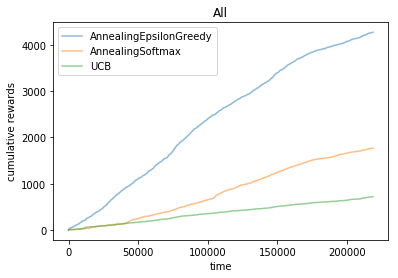

In [638]:
x = range(len(solutions))

plt.plot(x, cr_aeg, alpha=0.5, label='AnnealingEpsilonGreedy')
plt.plot(x, cr_asm, alpha=0.5, label='AnnealingSoftmax')
plt.plot(x, cr_ucb, alpha=0.5, label='UCB')

plt.legend()
plt.title(category)
plt.xlabel('time')
plt.ylabel('cumulative rewards')

plt.show()
plt.clf()
plt.cla()
plt.close()